# DBSCAN Clustering of Quake Tweets

We implement the DBSCAN algorithm in this notebook.

### Imports 

In [1]:
import os
import time
import pandas as pd
import geopandas as gpd
import preprocessor as p
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

### Read in the data

In [2]:
# Set data directory
data_dir = os.path.realpath("../data")

# Check if file exists
if os.path.exists(os.path.join(data_dir, "tweets.h5")):
    # Read tweets from htweets5
    tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")
else:
    # Convert tweets to htweets5
    # ? hdf manages large data well
    tweets = pd.read_csv(os.path.join(data_dir, "tweets.csv"))
    tweets.to_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

### Data Preprocessing

In [3]:
# Remove null longitude and latitude values
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
    (tweets.latitude > 42.33278)
    & (tweets.latitude < 51.08917)
    & (tweets.longitude > -4.795556)
    & (tweets.longitude < 8.230556)
]

# Set preprocessor options
p.set_options(p.OPT.URL)

# Remove URLs from the tweets
tweets['text'] = tweets['text'].apply(lambda x: p.clean(x))

# Convert createdAt to datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])

# Order tweets by createdAt
tweets.sort_values(by="createdAt", inplace=True)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames'], inplace=True)
except:
    pass

### Time parameter

<Axes: xlabel='createdAt'>

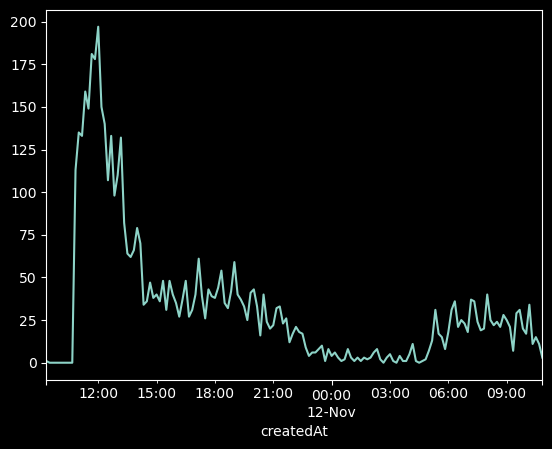

In [4]:
# Group tweets by 10 minutes and count the number of tweets
freq = '10min' 
tweets_freq = tweets.groupby(pd.Grouper(key='createdAt', freq=freq)).count()

# Rename the count column
tweets_freq.rename(columns={'text': 'count'}, inplace=True)

# Keep only the count column
tweets_freq = tweets_freq[['count']]

# Plot the number of tweets over time
tweets_freq['count'].plot()

### Preprocessing (Continued)

In [5]:
# Remove duplicates
# Test if wikidata column exists
if "wikidata" in tweets.columns:
    tweets.drop_duplicates(subset="wikidata", inplace=True)

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

# Convert tweets to geodataframe with crs
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")

# Convert crs to lambert93
tweets = tweets.to_crs("EPSG:2154")

# Calculate x and y coordinates and round them
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Move x_m and y_m after latitude and longitude
tweets = tweets[['text', 'entity', 'x_m', 'y_m', 'createdAt', 'geometry']]

In [6]:
tweets.head()

,text,entity,x_m,y_m,createdAt,geometry
id,,,,,,
1,il y a 23 min #seisme 2.0 a frappé Arbaz (Sion...,Arbaz,1037421.834,6583455.288,2019-11-11 09:23:24+00:00,POINT (1037421.834 6583455.288)
2,Tremblement de terre à Lyon en ce moment !!!,Lyon,843121.942,6519367.222,2019-11-11 10:53:46+00:00,POINT (843121.942 6519367.222)
3,Tremblement de terre en Ardèche à l'instant,Ardèche (département),812290.663,6397402.763,2019-11-11 10:54:09+00:00,POINT (812290.663 6397402.763)
4,Wait ! Y’a des tremblements de terre en France...,France,624015.535,6656012.010,2019-11-11 10:54:18+00:00,POINT (624015.535 6656012.010)
5,Koooo ya eu un tremblement de terre a montélim...,Montélimar,839040.238,6385934.220,2019-11-11 10:54:37+00:00,POINT (839040.238 6385934.220)


### Clustering using DBSCAN

In [7]:
# Convert lat and long to numpy array
COORDS = tweets[['x_m', 'y_m']].values

# Set DBSCAN parameters
# ? Higher minsamples or lower eps indicate higher density necessary to form a cluster
# ? On noisy and large datasets, higher min_samples is better
EPS = 25_000 # 20km
MIN_SAMPLES = 8

# Start timer
start = time.time()

# Create DBSCAN model
# ? Noise is labeled -1
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(COORDS)

# End timer
end = time.time()

# Print time taken
print("Time taken: {} seconds".format(end - start))

# Print number of clusters
print("Number of clusters: {}".format(len(set(db.labels_))))

# Store labels in tweets
tweets['cluster'] = db.labels_

Time taken: 0.005997896194458008 seconds
Number of clusters: 3


### Create convex hulls for each cluster

In [8]:
# Create a hulls geodataframe
hulls = gpd.GeoDataFrame(columns=['cluster', 'num_tweets', 'area_km2', 'geometry'])

for cluster in set(db.labels_):
    if cluster != -1:
        # Get the coordinates of the points in the cluster
        points = COORDS[db.labels_ == cluster]
        # Create a convex hull
        try:
            hull = ConvexHull(points)
        except:
            continue
        # Append the cluster and hull to the geodataframe using concat instead of append
        hulls = pd.concat([hulls, gpd.GeoDataFrame({
            'cluster': [cluster],
            'num_tweets': [len(points)],
            'geometry': [Polygon(points[hull.vertices])]
        })], ignore_index=True)

hulls.set_crs(epsg=2154, inplace=True)

# Calculate the area of the hulls
hulls['area_km2'] = round(hulls['geometry'].area / 1_000_000, 2)

In [9]:
hulls.head()

,cluster,num_tweets,area_km2,geometry
0,0,18,822.41,"POLYGON ((837347.766 6479894.351, 846327.439 6..."
1,1,45,6931.82,"POLYGON ((844235.501 6442558.927, 796293.367 6..."


### Plot the clusters

In [10]:
# Read France geojson
france = gpd.read_file(filename='../data/france.geojson')
france = france.to_crs("EPSG:2154")

Text(50.097222222222214, 0.5, 'X (km)')

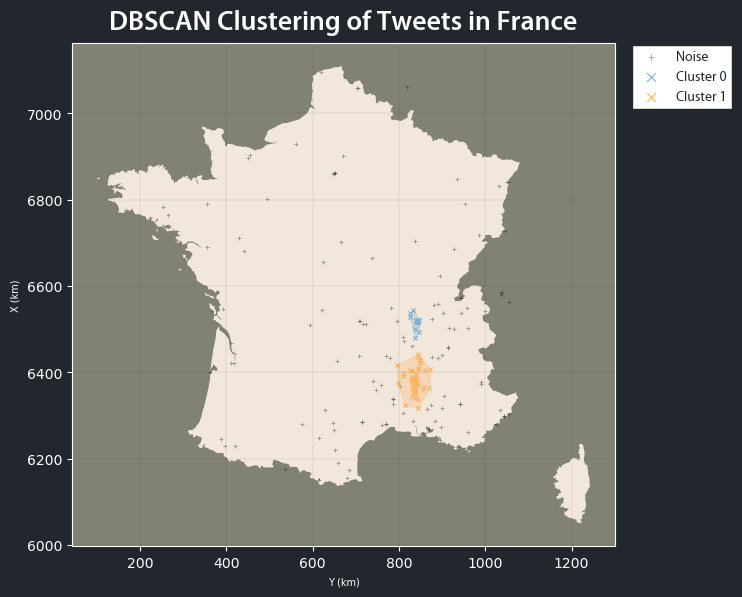

In [11]:
# Plot base map
base = france.plot(color='#F2E7DC', figsize=(7, 7), linewidth=0)
base.set_facecolor('#818274')
base.get_figure().patch.set_facecolor('#22272e')

# Plot tweets with cluster labels with different markers
for cluster in tweets.cluster.unique():
    tweets[tweets.cluster == cluster].plot(
        ax=base,
        markersize=6 if cluster == -1 else 10,
        label='Noise' if cluster == -1 else 'Cluster {}'.format(cluster),
        alpha=0.4 if cluster == -1 else 1,
        marker='x' if cluster != -1 else '+',
        color='#161819' if cluster == -1 else 'C{}'.format(cluster + 4),
        linewidth=0.6 if cluster == -1 else 0.8,
    )
    
for cluster in hulls.cluster:
    hulls[hulls.cluster == cluster].plot(
        ax=base,
        alpha=0.3,
        color='C{}'.format(cluster + 4),
        edgecolor='C{}'.format(cluster + 4),
        linewidth=1
    )

# Set title
base.set_title("DBSCAN Clustering of Tweets in France", fontsize=20, family='Myriad Pro', weight='medium', color='white', pad=10)

# Set legend
base.legend(loc='best', bbox_to_anchor=(1.23, 1.01), prop={'family': 'Myriad Pro', 'weight': 'book'}, fontsize=9, labelcolor='#22272e', markerscale=2, facecolor='white', title_fontsize=14, fancybox=False, framealpha=1, edgecolor='#22272e')

# Add grid
base.grid(color='#161819', linestyle='-', linewidth=0.2, alpha=0.3)

# Change tick labels
m2km = lambda x, _: f'{x/1000:g}'
base.xaxis.set_major_formatter(m2km)
base.yaxis.set_major_formatter(m2km)

# Set axis labels
base.set_xlabel("Y (km)", fontsize=7, labelpad=5)
base.set_ylabel("X (km)", fontsize=7, labelpad=5)

In [12]:
# Save figure
base.get_figure().savefig('../images/dbscan.png', dpi=300, bbox_inches='tight', facecolor=base.get_figure().get_facecolor(), edgecolor='none')